# Evaluate CCLM soil temperature with ERA5 and ERA5-Land

In [1]:
from pathlib import Path

import xarray as xr
import pandas as pd

import valenspy as vp #The Valenspy package
from valenspy.inputconverter_functions import ERA5_to_CF, CCLM_to_CF
from valenspy._utilities import load_xarray_from_data_sources
from eval_functions import * 
from yaml import safe_load

import numpy as np
import matplotlib.pyplot as plt


In [2]:

def geo_to_rot(coord, ds):
    ###
    # Converts a geographic (lon,lat) point to an (rlon,rlat) point
    # => coord: geographic lon - lat couple (degrees) => list or tuple
    # => ds: xarray dataset of a CCLM file
    ###
    # Read in COSMO-CLM data

    rp_lat = float(ds.rotated_pole.grid_north_pole_latitude)
    rp_lon = float(ds.rotated_pole.grid_north_pole_longitude)
    # Convert 
    co = np.deg2rad(coord)
    rp_lat = np.deg2rad(rp_lat); rp_lon = np.deg2rad(rp_lon)
    p_rlat = np.arcsin(np.sin(co[1])*np.sin(rp_lat) + np.cos(co[1])*np.cos(rp_lat)*np.cos(co[0]-rp_lon)) 
    p_rlon = np.arctan((np.cos(co[1])*np.sin(co[0]-rp_lon)) / (np.cos(co[1])*np.sin(rp_lat)*np.cos(co[0]-rp_lon) - np.sin(co[1])*np.cos(rp_lat))) 
    p_rlat = np.rad2deg(p_rlat); p_rlon = np.rad2deg(p_rlon)
    # Return rlon-rlat couple
    return [p_rlon,p_rlat]

In [3]:
machine = "hortense"
variable = "tsl"
ref_dataset = "ERA5"


experiments = ["EUR11_CO_TA_GC_TSO",
               "EUR11_CO_TT_GC_TSO", 
               "EUR11_CO_TT_EC_TSO", 
               "EUR11_NU_TE_GC_TSO", 
               "EUR11_NU_TT_GC_TSO", 
               "EUR11_NU_TT_EC_TSO"]


# Define the coordinates
d_point_coords = {
    'opwijk'    : (4.18, 50.97), 
    'bertrix'    : (5.25, 49.854),
}
point_id = 'opwijk'
point_coord = d_point_coords[point_id]


months_to_analyse = [6,7,8]


In [4]:
# ERA5 files (manually loaded and converted)
obs_files = ['/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/soil_temperature_level_1/era5-hourly-europe-soil_temperature_level_1-1995.nc', 
'/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/soil_temperature_level_2/era5-hourly-europe-soil_temperature_level_2-1995.nc', 
'/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/soil_temperature_level_3/era5-hourly-europe-soil_temperature_level_3-1995.nc', 
'/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/soil_temperature_level_4/era5-hourly-europe-soil_temperature_level_4-1995.nc']





In [5]:
def plot_point_soiltemperature(ref_dataset, obs_files, variable, experiments, point_coord, point_id,  months_to_analyse, ax=False): 


    # 1. manually load ERA5

    ds = load_xarray_from_data_sources(obs_files)

    # rename dimensions if not yet renamed
    if "lon" not in ds.coords:
        ds = ds.rename({"longitude": "lon"})
    if "lat" not in ds.coords:
        ds = ds.rename({"latitude": "lat"})

    # make sure lat and lon are sorted ascending
    ds = ds.sortby('lat').sortby('lon')

    # bugfix ERA5 (found in clh): replace valid_time by time
    if "time" not in ds: 
        ds = ds.rename({'valid_time':'time'})

    ds = ds.resample(time='1D').mean()  


    # hardcoded from https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Parameterlistings 

    era5_soillayers = {'soil_depth': [0.07,0.28,1,2.89], 'thickness': [0.07,0.21,0.72,1.89], 
    'layer': ['0 - 7 cm','7 - 28 cm', '28 - 100 cm ', '100 - 289 cm']} #m 

    da_obs= xr.concat([ds['stl1'], ds['stl2'], ds['stl3'], ds['stl4']], dim='soil_depth')

    da_obs['soil_depth'] = era5_soillayers['soil_depth']

    ds_obs = da_obs.to_dataset(name=variable)

    # select point from obs

    ds_obs_point = ds_obs.sel(lon=point_coord[0],lat=point_coord[1], method='nearest')
    da_obs_point = ds_obs_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))
    da_obs_point_timmean = da_obs_point.mean('time')

    # 2. Load CCLM experiments

    src_path = Path("../src/valenspy")

    # define postprocessing base directory of CCLM
    postproc_base_dir = "/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/"

    # get experiment name

    # get the file directory based on the model name. 

    # reference dataset to compare to
    model_name = 'CCLM'

    # get lookup file for model
    with open(src_path / "ancilliary_data" / Path(model_name+"_lookup.yml")) as file:
        mod_LOOKUP = safe_load(file)



    # get CCLM variable corresponding to the requested variable using its look-up table
    mod_var = mod_LOOKUP[variable]['mod_name']


    d_da_mod_point = {}
    for experiment in experiments: 

        # define the path
        directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/')

        # define the CCLM files for the corresponding variable
        cclm_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory

        #Import Converter - This input converter will not do anything to the data.
        ic = vp.InputConverter(CCLM_to_CF)
        ds_mod = ic.convert_input(cclm_files) # Convert the input to the correct format

        ds_mod = ds_mod.rename({'soil1':'soil_depth'})

        coord_points_rotated = geo_to_rot(point_coord, ds_mod)
        ds_mod_point = ds_mod.sel(rlon = coord_points_rotated[0], rlat = coord_points_rotated[1], method='nearest')

        da_mod_point = ds_mod_point[variable].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))

        da_mod_point_timmean = da_mod_point.mean('time')

        d_da_mod_point[experiment] = da_mod_point_timmean



    if not ax: 
        fig, ax = plt.subplots(figsize = (7,3))

    ax.plot(da_obs_point_timmean.values, da_obs_point_timmean['soil_depth'].values, color='k', label = ref_dataset)
    for experiment in experiments: 
        ax.plot(d_da_mod_point[experiment].values, d_da_mod_point[experiment]['soil_depth'].values,  label=experiment)

    ax.invert_yaxis()
    ax.set_title(' ', loc='center')
    ax.set_title(f"{point_id} ({point_coord[1]}°N,  {point_coord[0]}°E)", loc='right');
    #ax.set_title(f"Mean soil temperature in {months_to_analyse}", loc='left')
    ax.set_ylabel('Soil depth (m)')
    ax.set_ylim([12,-0.5])
    
    ax.axhlines(da_mod_point_timmean.soil_depth.values, color="gray", linewidth = 0.5)

    return ax



In [6]:
def plot_timeseries_twopoints(variable, ref_dataset, obs_files, experiments, d_point_coords,  months_to_analyse):

    "Wrapper function to combine 4 point timeseries plot into one figure, with nice layout (legend and title)"
    fig, axes = plt.subplots(1,2,figsize = (6,5))
    axes = axes.flatten()

    for i,point_id in enumerate(d_point_coords): 
        ax = axes[i]
        ax = plot_point_soiltemperature(ref_dataset, obs_files, variable, experiments, d_point_coords[point_id], point_id,  months_to_analyse, ax=ax)
        if i ==1: 
            ax.legend(frameon=False, loc='lower right')

    fig.tight_layout()

Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of t

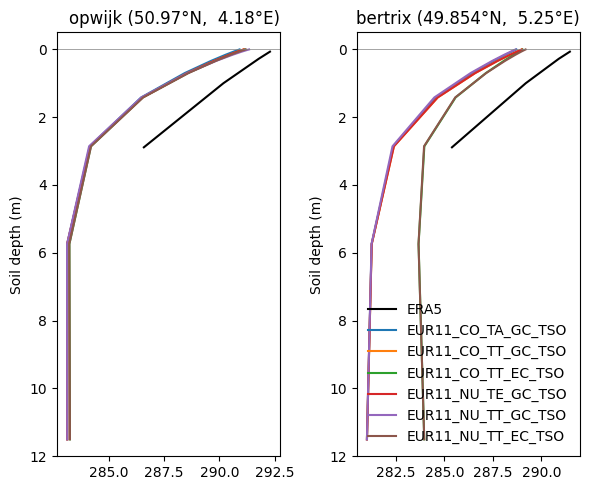

In [27]:
plot_timeseries_twopoints(variable, ref_dataset, obs_files, experiments, d_point_coords,  months_to_analyse)

## raw code

In [14]:
    # 1. manually load ERA5

    ds = load_xarray_from_data_sources(obs_files)

    # rename dimensions if not yet renamed
    if "lon" not in ds.coords:
        ds = ds.rename({"longitude": "lon"})
    if "lat" not in ds.coords:
        ds = ds.rename({"latitude": "lat"})

    # make sure lat and lon are sorted ascending
    ds = ds.sortby('lat').sortby('lon')

    # bugfix ERA5 (found in clh): replace valid_time by time
    if "time" not in ds: 
        ds = ds.rename({'valid_time':'time'})

    ds = ds.resample(time='1D').mean()  


    # hardcoded from https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Parameterlistings 

    era5_soillayers = {'soil_depth': [0.07,0.28,1,2.89], 'thickness': [0.07,0.21,0.72,1.89], 
    'layer': ['0 - 7 cm','7 - 28 cm', '28 - 100 cm ', '100 - 289 cm']} #m 

    da_obs= xr.concat([ds['stl1'], ds['stl2'], ds['stl3'], ds['stl4']], dim='soil_depth')

    da_obs['soil_depth'] = era5_soillayers['soil_depth']

    ds_obs = da_obs.to_dataset(name=variable)

    # select point from obs

    ds_obs_point = ds_obs.sel(lon=point_coord[0],lat=point_coord[1], method='nearest')
    da_obs_point = ds_obs_point[variable].sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))
    da_obs_point_timmean = da_obs_point.mean('time')

    # 2. Load CCLM experiments

    src_path = Path("../src/valenspy")

    # define postprocessing base directory of CCLM
    postproc_base_dir = "/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/"

    # get experiment name

    # get the file directory based on the model name. 

    # reference dataset to compare to
    model_name = 'CCLM'

    # get lookup file for model
    with open(src_path / "ancilliary_data" / Path(model_name+"_lookup.yml")) as file:
        mod_LOOKUP = safe_load(file)



    # get CCLM variable corresponding to the requested variable using its look-up table
    mod_var = mod_LOOKUP[variable]['mod_name']


    d_da_mod_point = {}
    d_ds_mod = {}

    for experiment in experiments: 

        # define the path
        directory = Path(postproc_base_dir + experiment +'/'+mod_var + '/')

        # define the CCLM files for the corresponding variable
        cclm_files = list(directory.glob(mod_var+"_daymean.nc")) # Select all the netCDF files in the directory

        #Import Converter - This input converter will not do anything to the data.
        ic = vp.InputConverter(CCLM_to_CF)
        ds_mod = ic.convert_input(cclm_files) # Convert the input to the correct format

        ds_mod = ds_mod.rename({'soil1':'soil_depth'})
        d_ds_mod[experiment] = ds_mod
        coord_points_rotated = geo_to_rot(point_coord, ds_mod)
        ds_mod_point = ds_mod.sel(rlon = coord_points_rotated[0], rlat = coord_points_rotated[1], method='nearest')

        da_mod_point = ds_mod_point[variable].sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))

        da_mod_point_timmean = da_mod_point.mean('time')

        d_da_mod_point[experiment] = da_mod_point_timmean

Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tsl']
Unknown to ValEnsPy: ['time_bnds', 'rotated_pole', 'soil1_bnds']
Variable metadata is missing or incorrect
The file is NOT ValEnsPy CF compliant.
25.00% of t

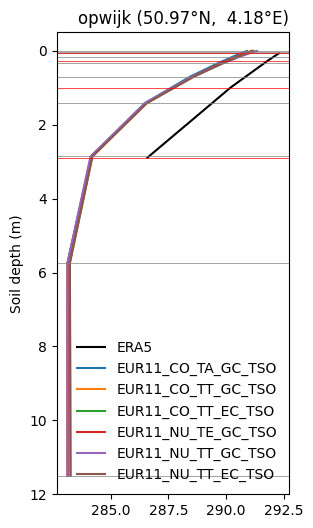

In [8]:
fig, ax = plt.subplots(figsize = (3,6))

ax.plot(da_obs_point_timmean.values, da_obs_point_timmean['soil_depth'].values, color='k', label = ref_dataset)
for experiment in experiments: 
    ax.plot(d_da_mod_point[experiment].values, d_da_mod_point[experiment]['soil_depth'].values,  label=experiment)

ax.invert_yaxis()
ax.set_title(' ', loc='center')
ax.set_title(f"{point_id} ({point_coord[1]}°N,  {point_coord[0]}°E)", loc='right');
#ax.set_title(f"Mean soil temperature in {months_to_analyse}", loc='left')
ax.set_ylabel('Soil depth (m)')
ax.set_ylim([12,-0.5])

ax.legend(frameon=False, loc='lower right')


for soil_depth in da_mod_point_timmean.soil_depth.values: 
    ax.axhline(soil_depth, color="gray", linewidth = 0.5, label='CCLM soil levels')
    
for soil_depth in da_obs_point_timmean.soil_depth.values: 
    ax.axhline(soil_depth, color="red", linewidth = 0.5, linestyle='-')



### plot bias map for lowest soil layer ERA5 (2m89), and corresponding CCLM layer at 2m86

In [10]:
# define bounds 
bounds = {'europe':
                    {'lat_bounds': [35,70], 
                    'lon_bounds': [-15,40]}, 
        'belgium': 
                    {'lat_bounds': [49,52], 
                    'lon_bounds': [2,7]}}

/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as 

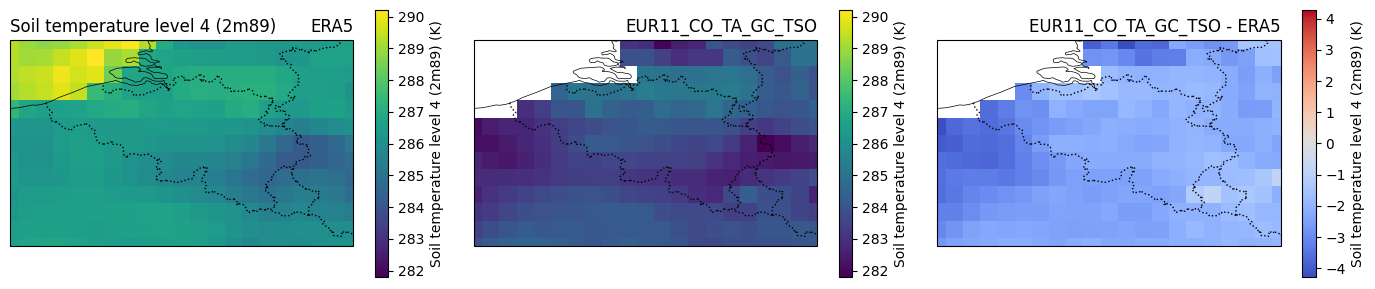

/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as 

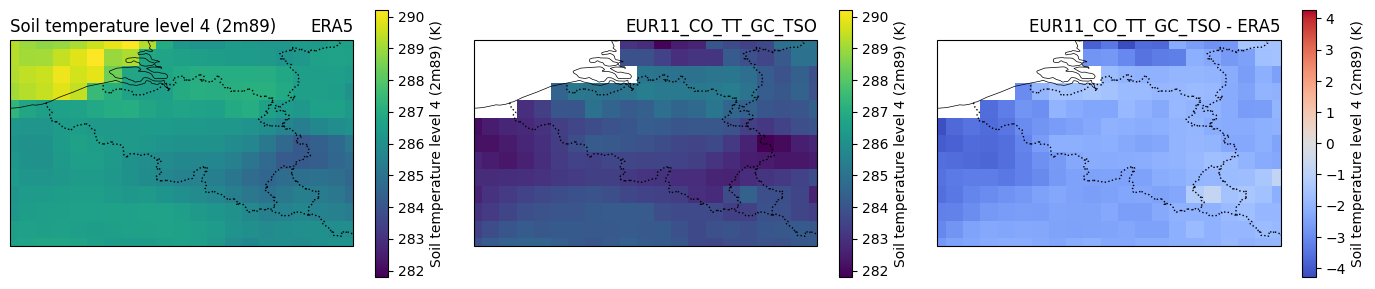

/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as 

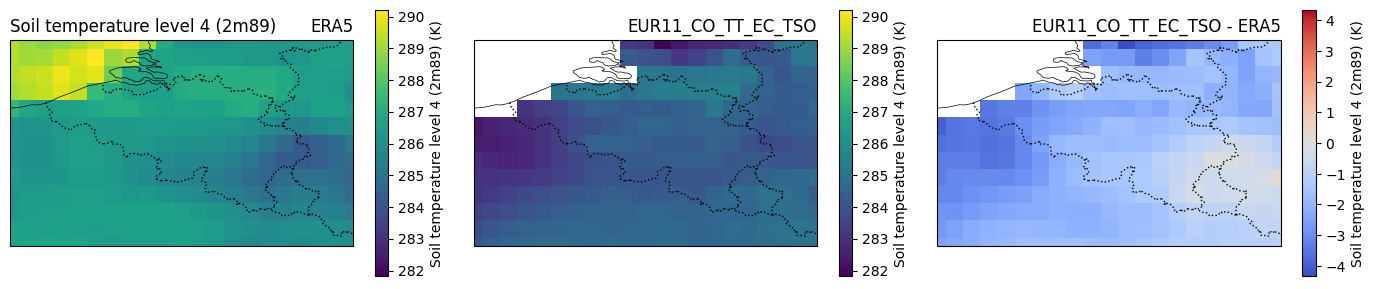

/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as 

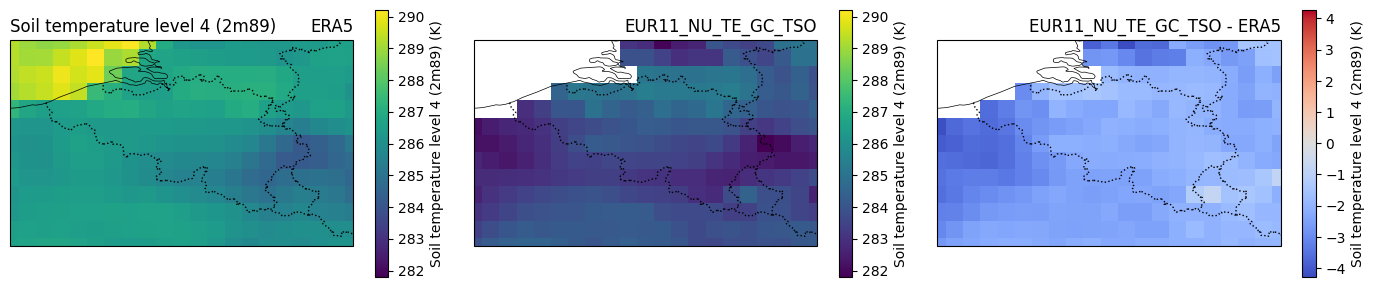

/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as 

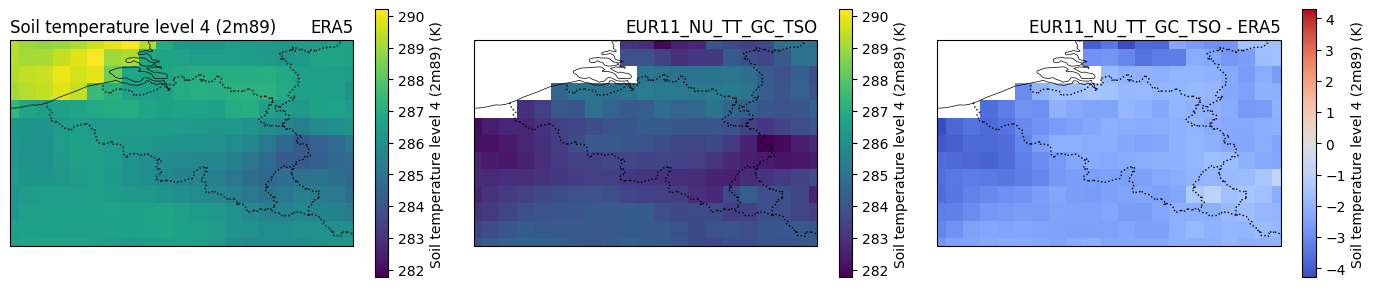

/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/innev/miniconda3/envs/env_geo/lib/python3.12/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as 

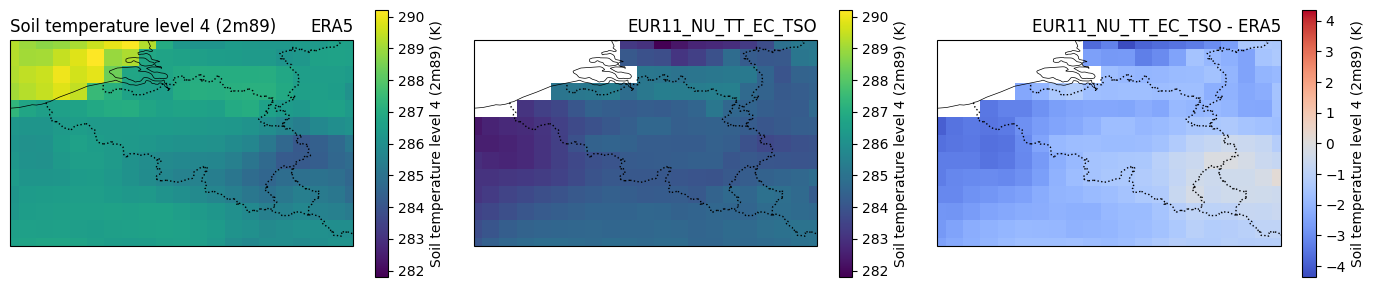

In [19]:
region='belgium'

gridfile = '/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/2m_temperature/era5-hourly-europe-2m_temperature-1995.nc'


da_obs_sel = ds_obs['tsl'].sel(soil_depth=2.89).sel(time=ds_obs['time'].dt.month.isin(months_to_analyse))
da_obs_sel.attrs['long_name'] =  'Soil temperature level 4 (2m89)'


for experiment in experiments: 
    ds_mod = d_ds_mod[experiment]
    ds_mod = remap_cdo(gridfile, ds_mod, remap_method = "bil")
    ds_mod = ds_mod.sortby('lat')

    da_mod_sel = ds_mod['tsl'].sel(soil_depth=2.86).sel(time=ds_mod['time'].dt.month.isin(months_to_analyse))


    calc_and_plot_timmean_bias(region, bounds, da_mod_sel, da_obs_sel, experiment, ref_dataset)